# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mse_function(a:np.ndarray, b:np.ndarray):
   return np.mean((a - b)**2)  # Mean Squared Error
def mse_function_derivative(a:np.ndarray, b:np.ndarray):
    return 2*(a - b)/b.size

In [3]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.rand(self.input_size, self.output_size) - 0.5
        self.biases = np.random.rand(1, self.output_size) - 0.5


    def forward(self, x_input:np.ndarray)->np.ndarray:
        self.input = x_input.reshape(1, self.input_size)
        self.output = np.dot(self.input, self.weights) + self.biases
        return self.output

    def backward(self, output_error_derivative)->np.ndarray:
        '''Maths:
                output_error_derivative: dE/dz
                input_error_derivative:  dE/dx = dE/dz * dz/dx (=weights)
                weight_error_derivative: dE/dw = dE/dz * dz/dw (=inputs)
                bias_error_derivative:   dE/db = dE/dz * dz/db (=1) = dE/dz
        '''
        input_error_derivative = np.dot(output_error_derivative, self.weights.T)
        weight_error_derivative =  np.dot(self.input.T, output_error_derivative)
        bias_error_derivative = output_error_derivative

        # gradient descent
        self.weights -= weight_error_derivative * self.learning_rate
        self.biases -= bias_error_derivative * self.learning_rate
        return input_error_derivative

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative)->np.ndarray:
        input_error_derivative = (1 - np.tanh(self.input)**2) * output_error_derivative
        return input_error_derivative

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(x)

    def loss_derivative(self, x:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate  # unused

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x_input:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        output = x_input
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def analyze_average_error(self, x_test:np.ndarray, y_test:np.ndarray, verbose=0) -> float:
        error_averages = []
        successess = 0
        for test_index in range(len(x_test)):
            computed_output = self.__call__(x_test[test_index])
            error_averages.append(mse_function(computed_output, y_test[test_index]))
            if np.argmax(computed_output) == np.argmax(y_test[test_index]):
                successess+=1
        accuracy = successess/len(x_test) *100
        if verbose>0:
            print(f"Average error for test data is: {np.mean(error_averages)}, Accuracy: {accuracy}%")
        return accuracy

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            learning_rate:float,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        for _ in range(epochs):
            for training, x_train_sample in enumerate(x_train):
                loss_function = lambda x: mse_function(x, y_train[training])
                loss_derivative = lambda x: mse_function_derivative(x,  y_train[training])
                self.compile(Loss(loss_function, loss_derivative))
                output = x_train_sample
                for layer in self.layers:
                    layer.learning_rate = learning_rate
                    output = layer.forward(output)
                if verbose>0:
                    print("Loss:", self.loss.loss(output))
                input = self.loss.loss_derivative(output)
                for layer in reversed(self.layers):
                    input = layer.backward(input)

# XOR gate test

In [4]:
x_train_xor = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train_xor = np.array([[[1.,0.]], [[0.,1.]], [[0.,1.]], [[1.,0.]]])
net = Network([FullyConnected(2,10), Tanh(), FullyConnected(10,4), Tanh(), FullyConnected(4,2), Tanh()], 0.1)
net.fit(x_train_xor, y_train_xor, 1000, 0.1)
for test_index in range(len(x_train_xor)):
    print("Results: ", np.argmax(net.__call__(x_train_xor[test_index])), end="  ")
    print("Disired value: ", np.argmax(y_train_xor[test_index]))
net.analyze_average_error(x_train_xor, y_train_xor, 1)

Results:  0  Disired value:  0
Results:  1  Disired value:  1
Results:  1  Disired value:  1
Results:  0  Disired value:  0
Average error for test data is: 0.0002420276696094266, Accuracy: 100.0%


100.0

# MNIST data

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [6]:
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
# mnist.DESCR
# mnist.data
# mnist.target.shape

In [8]:
def normalize_to_vector(k:int):
    """Integer k to matrix of zeros with 1 on k-th element"""
    arr = np.zeros(10)
    arr[k] +=1
    return arr
def normalized_mnist_data(data:List[np.ndarray]):
    for i in range(len(data)):
        if i < 2:
            data[i] = data[i].to_numpy()
            data[i] /= 255
        else:
            data[i] = data[i].to_numpy(dtype=int)
            data[i] = np.array([normalize_to_vector(number) for number in data[i]])
    return data

In [9]:
def network_test(layers, learning_rate=0.1, epochs=1, verbose=0) -> List[float]:
    result_averages = []
    for i, state in enumerate([42,123,51]):
        data = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=state)
        data = normalized_mnist_data(data)
        x_train, x_test, y_train, y_test = data
        n = Network(layers, learning_rate)
        n.fit(x_train, y_train, epochs, learning_rate)
        if verbose>0:
            print(f"{i+1}. seed results: ")
        result_averages.append(n.analyze_average_error(x_test, y_test, verbose=verbose))
    return result_averages


In [10]:
def analyze_network(layer_number=4, number_of_neurons_in_layer=50, learning_rate=0.1):
    layers = []
    input = 28**2
    output = number_of_neurons_in_layer

    for ln in range(layer_number):
        if ln == (layer_number -1):
            output = 10
        layers.append(FullyConnected(input, output))
        layers.append(Tanh())
        input = output
    return network_test(layers, learning_rate)

In [11]:
def plot_accuracy_variation(parameter_values, parameter_name):

    accuracy_seed_1 = []
    accuracy_seed_2 = []
    accuracy_seed_3 = []

    for param_value in parameter_values:
        if parameter_name == 'layer_number':
            accuracies = analyze_network(layer_number=param_value)
        elif parameter_name == 'number_of_neurons_in_layer':
            accuracies = analyze_network(number_of_neurons_in_layer=param_value)
        elif parameter_name == 'learning_rate':
            accuracies = analyze_network(learning_rate=param_value)

        accuracy_seed_1.append(accuracies[0])
        accuracy_seed_2.append(accuracies[1])
        accuracy_seed_3.append(accuracies[2])

    parameter_values = np.array(parameter_values)
    accuracy_seed_1 = np.array(accuracy_seed_1)
    accuracy_seed_2 = np.array(accuracy_seed_2)
    accuracy_seed_3 = np.array(accuracy_seed_3)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(parameter_values, accuracy_seed_1, label='Accuracy for seed 1', marker='o')
    ax.plot(parameter_values, accuracy_seed_2, label='Accuracy for seed 2', marker='o')
    ax.plot(parameter_values, accuracy_seed_3, label='Accuracy for seed 3', marker='o')
    ax.set(xlabel=parameter_name.capitalize(), ylabel='Accuracy', title=f'Accuracy Variation for {parameter_name.capitalize()}')
    ax.legend()
    plt.show()

# Eksperymenty

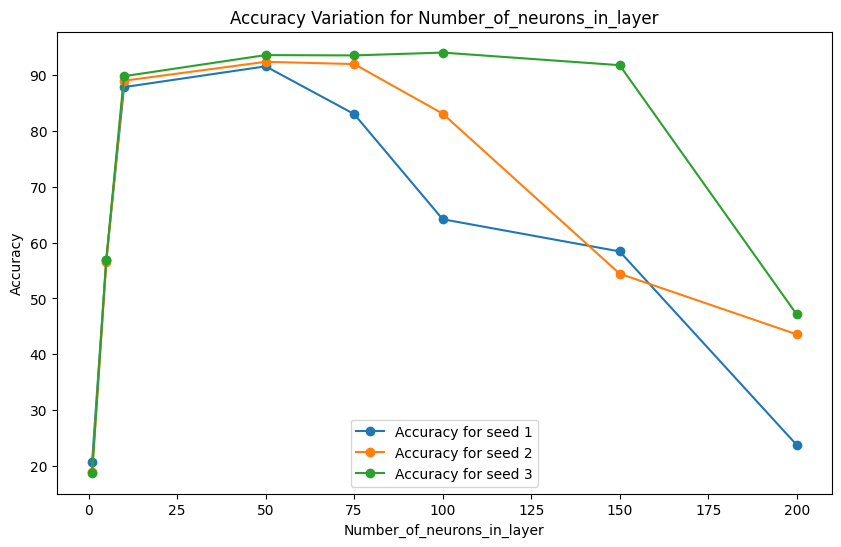

In [12]:
number_of_neurons_values = [1, 5, 10, 50, 75, 100, 150, 200]
plot_accuracy_variation(number_of_neurons_values, 'number_of_neurons_in_layer')

Parametry dla tych sieci to 4 warstwy i learning rate 0.1 oraz liczba neuronów w każdej sieci z zakresu [1, 5, 10, 50, 75, 100, 150, 200]. Spadek dla większej ilości spowodowany jest za dużym learning rate i przy tak wielu neuronach sieć robi za duże kroki i nie działa poprawnie.

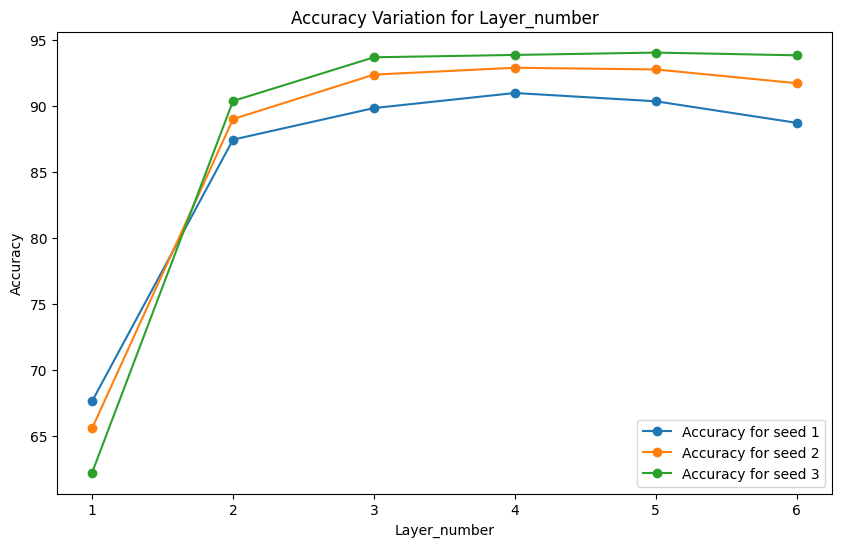

In [13]:
layer_number_values = [1, 2, 3, 4, 5, 6]
plot_accuracy_variation(layer_number_values, 'layer_number')

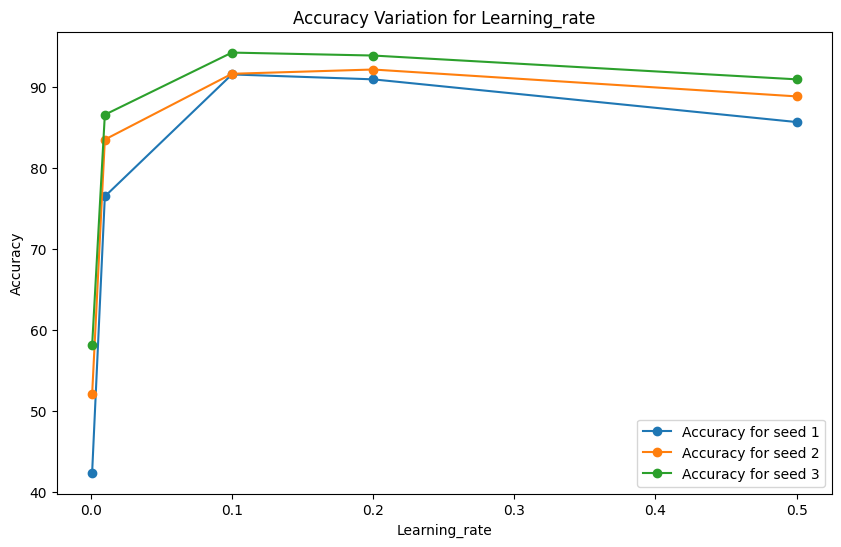

In [14]:
learning_rate_values = [0.001, 0.01, 0.1, 0.2, 0.5]
plot_accuracy_variation(learning_rate_values, 'learning_rate')

Więcej epizodów (epochs) nie przynosi za dużych efektów, więc wnioskuje, że siec się już wystarczająco nauczyła dostarczonych danych i do jej rozwoju potrzebna jest raczej większa ilość danych

In [15]:
network_test([FullyConnected(28**2, 10), Tanh(), FullyConnected(10, 5), Tanh(), FullyConnected(5, 10), Tanh()], epochs=5, verbose=1)

1. seed results: 
Average error for test data is: 0.045569121738912206, Accuracy: 58.8%
2. seed results: 
Average error for test data is: 0.04571259805496701, Accuracy: 56.92857142857143%
3. seed results: 
Average error for test data is: 0.0466390149841042, Accuracy: 57.95714285714286%


[58.8, 56.92857142857143, 57.95714285714286]

# Wnioski

Udało się poprawnie zaimplementować perceptron wielowarstwowy i zaimplementować metodę propagacji wstecznej wykorzystując algorytm optymalizacji gradientowej.
Skuteczność algorytmu została przetestowana dla różnych parametrów tj. liczba warstw, liczba neuronów w warstwach, kroku (learning rate). W tym weryfikacji poprawności wykorzystano dane reprezentujące działanie bramki XOR oraz dane ze zbioru danych MNIST (rozpoznawanie ręcznie pisanych cyfr).
Jak obserwujemy, zwiększenie liczby warstw i neuronów w warstwach (z odpowiednio dostrojonym parametrem learning rate) poprawnia skuteczność wytrenowania sieci.

Bibliografia:



1.   https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
2. Sztuczna inteligencja dla inżynierów. Metody ogólne
3. https://www.youtube.com/watch?v=i94OvYb6noo
4. https://www.youtube.com/watch?v=tIeHLnjs5U8
5. https://medium.com/@vaibhav1403/fully-connected-layer-f13275337c7c
6. https://mahendra-choudhary.medium.com/mnist-handwritten-digits-recognition-using-scikit-learn-36161768d10e
7. https://www.baeldung.com/cs/epoch-neural-networks
https://en.wikipedia.org/wiki/MNIST_database